In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from tueplots import figsizes
import matplotlib as mpl

from histaug.analysis.bootstrap import compare_bootstraps
from histaug.analysis.collect_results import load_results
from histaug.utils.display import RENAME_MODELS, RENAME_FEATURE_EXTRACTORS, FEATURE_EXTRACTOR_GROUPS

In [3]:
MAGNIFICATION = "low"
# MAGNIFICATION = "high"

models = ["AttentionMIL", "Transformer", "MeanAveragePooling"] if MAGNIFICATION == "low" else ["AttentionMIL"]

from histaug.analysis.collect_results import compute_results_table
from histaug.utils import rc_context, savefig


def compute_overall_average(df):
    # Computer overall mean and std (across targets)
    targets = df.columns.get_level_values("target").unique()
    assert "average" not in targets
    n_targets = len(targets)
    overall_mean = df.stack().query("stats == 'mean'").droplevel("stats").sum(axis="columns").divide(n_targets)
    overall_std = (
        df.stack().query("stats == 'std'").droplevel("stats").pow(2).sum(axis="columns").divide(n_targets).pow(0.5)
    )
    df["average", "mean"] = overall_mean
    df["average", "std"] = overall_std
    return df


def format_feature_extractor(new_name: str):
    if new_name in FEATURE_EXTRACTOR_GROUPS:
        new_name = f"\\textbf{{{new_name}}}"
    # new_name = f"\\textsf{{{new_name}}}"
    return new_name


results = load_results()

2024-05-28 15:40:22.313 | DEBUG    | histaug.utils.caching:wrapper:20 - Loading results from cache


2024-05-28 15:40:22.385 | DEBUG    | histaug.utils.caching:wrapper:20 - Loading norm_diff__feature_extractor__magnification_augmentations_model_target from cache


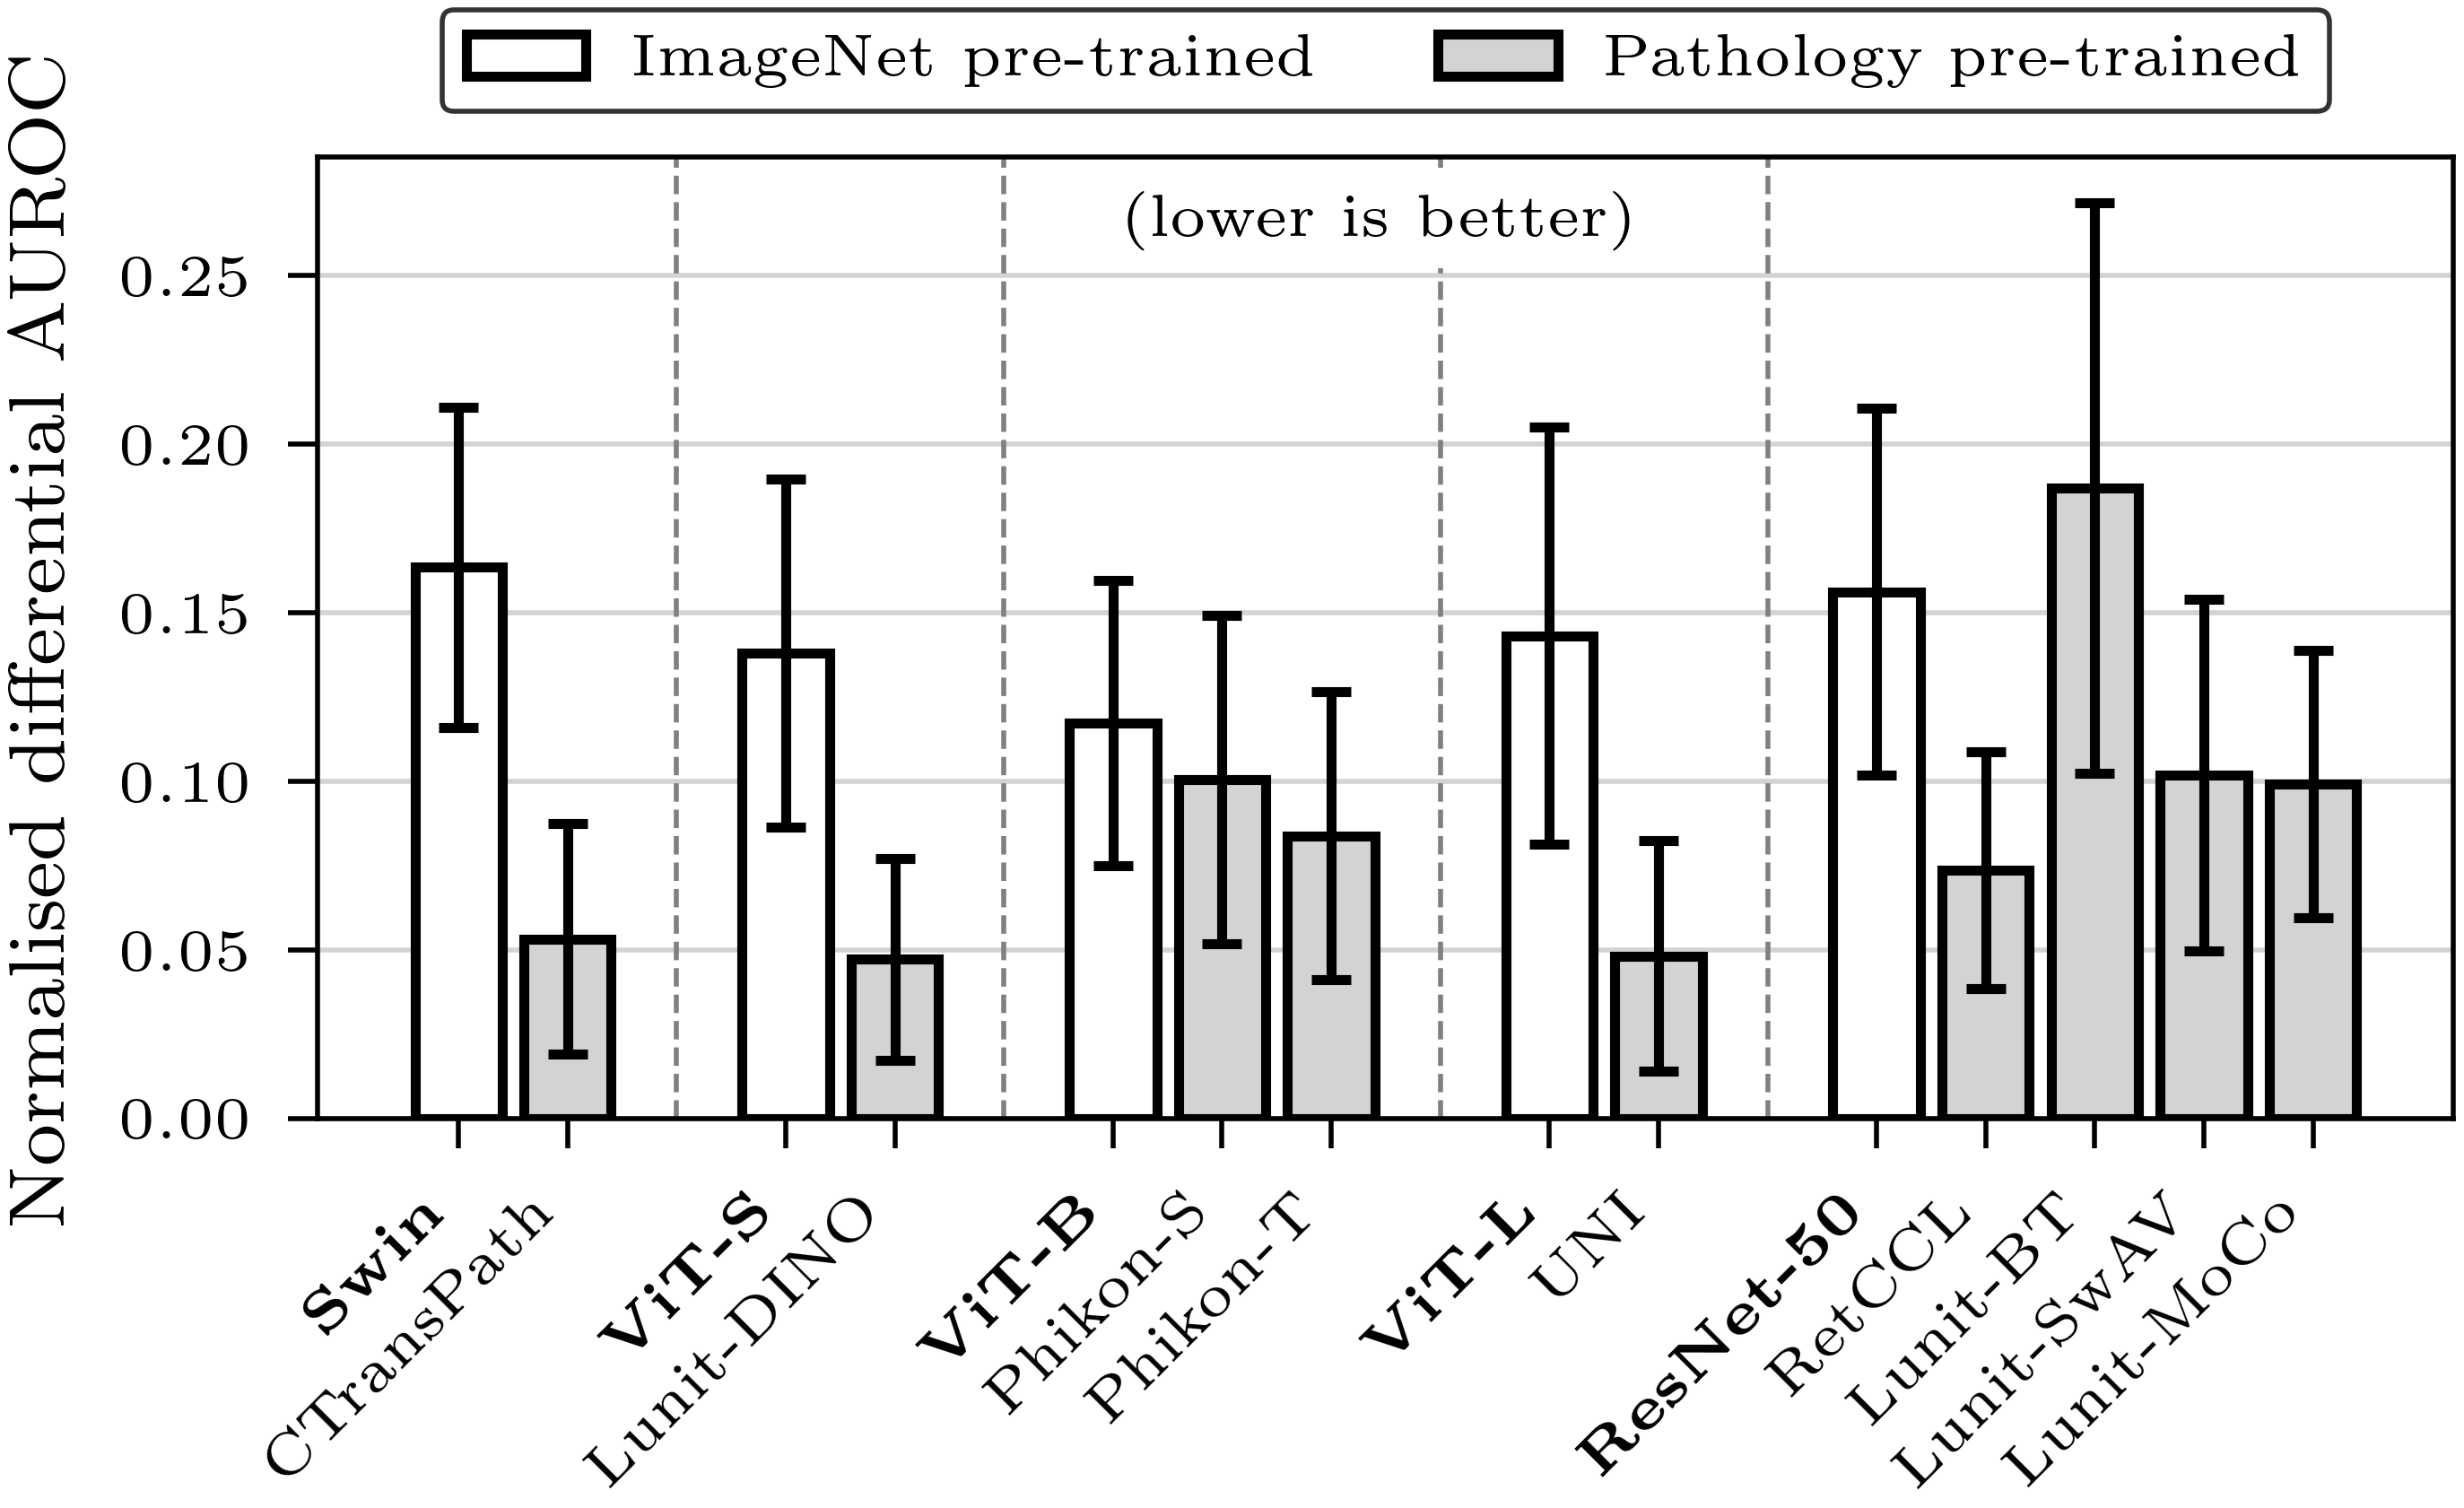

2024-05-28 15:40:25.097 | DEBUG    | histaug.utils.caching:wrapper:20 - Loading norm_diff__feature_extractor__magnification_augmentations_model_target from cache


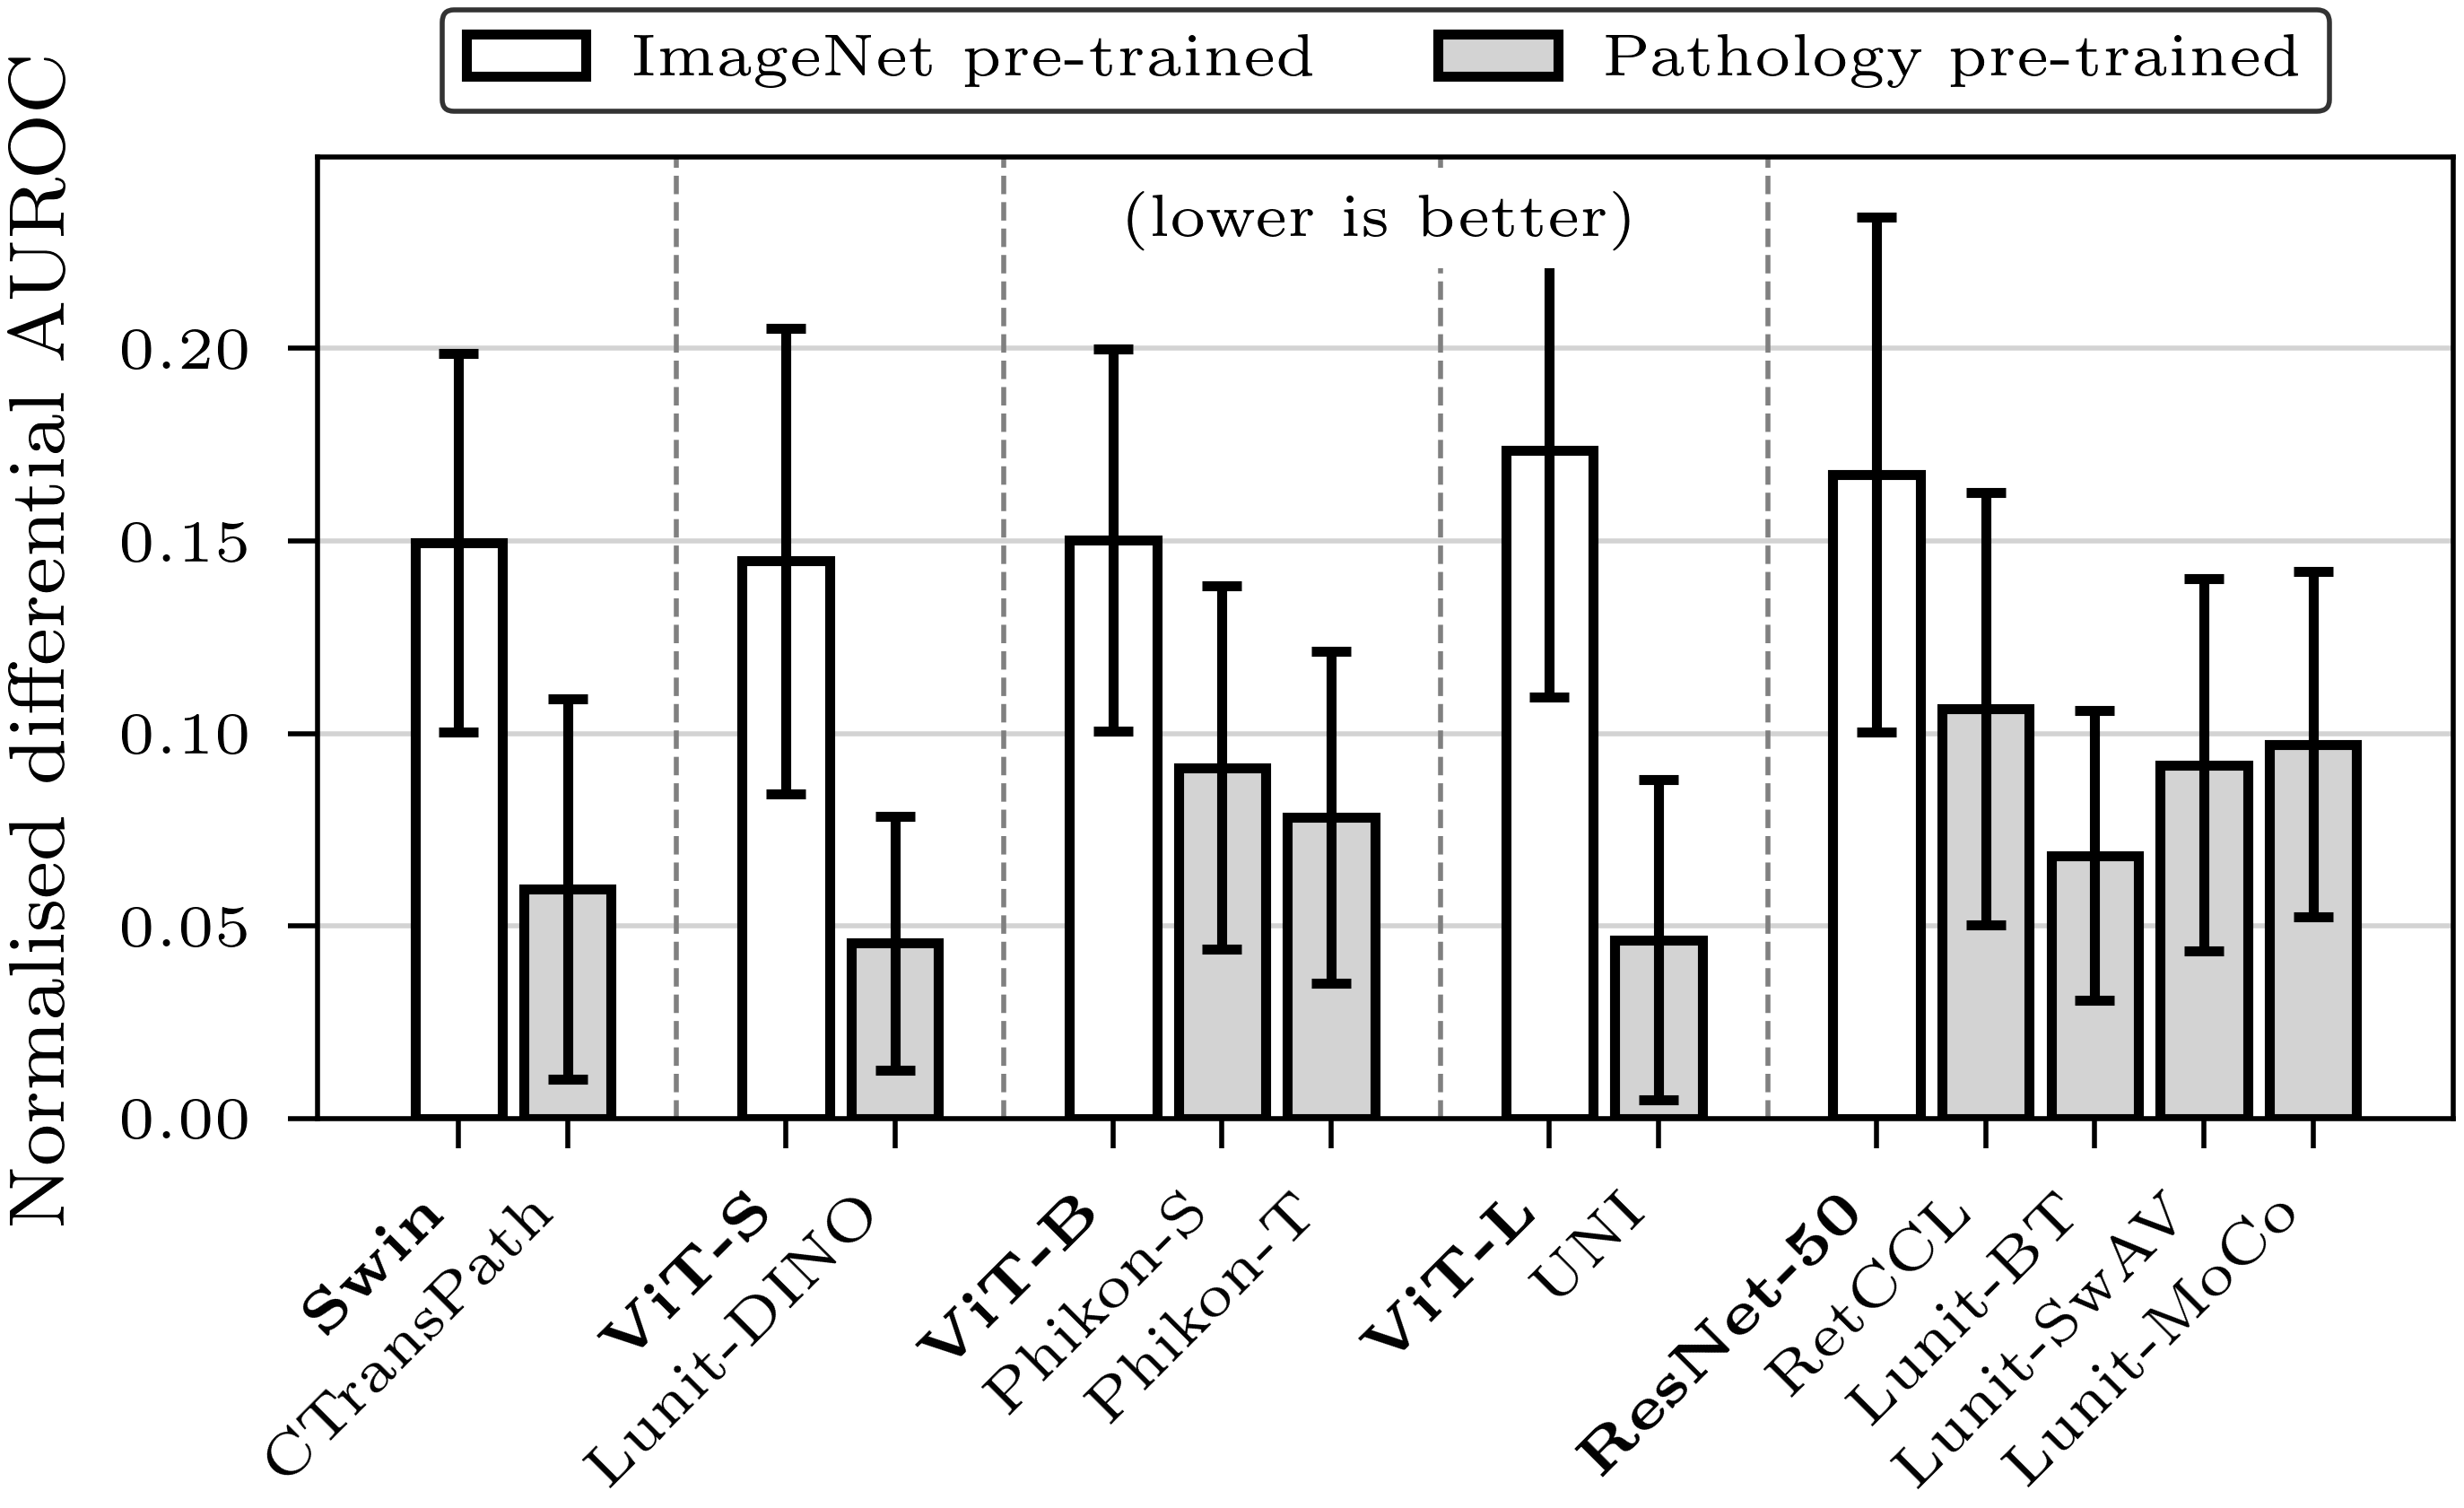

2024-05-28 15:40:27.477 | DEBUG    | histaug.utils.caching:wrapper:20 - Loading norm_diff__feature_extractor__magnification_augmentations_model_target from cache


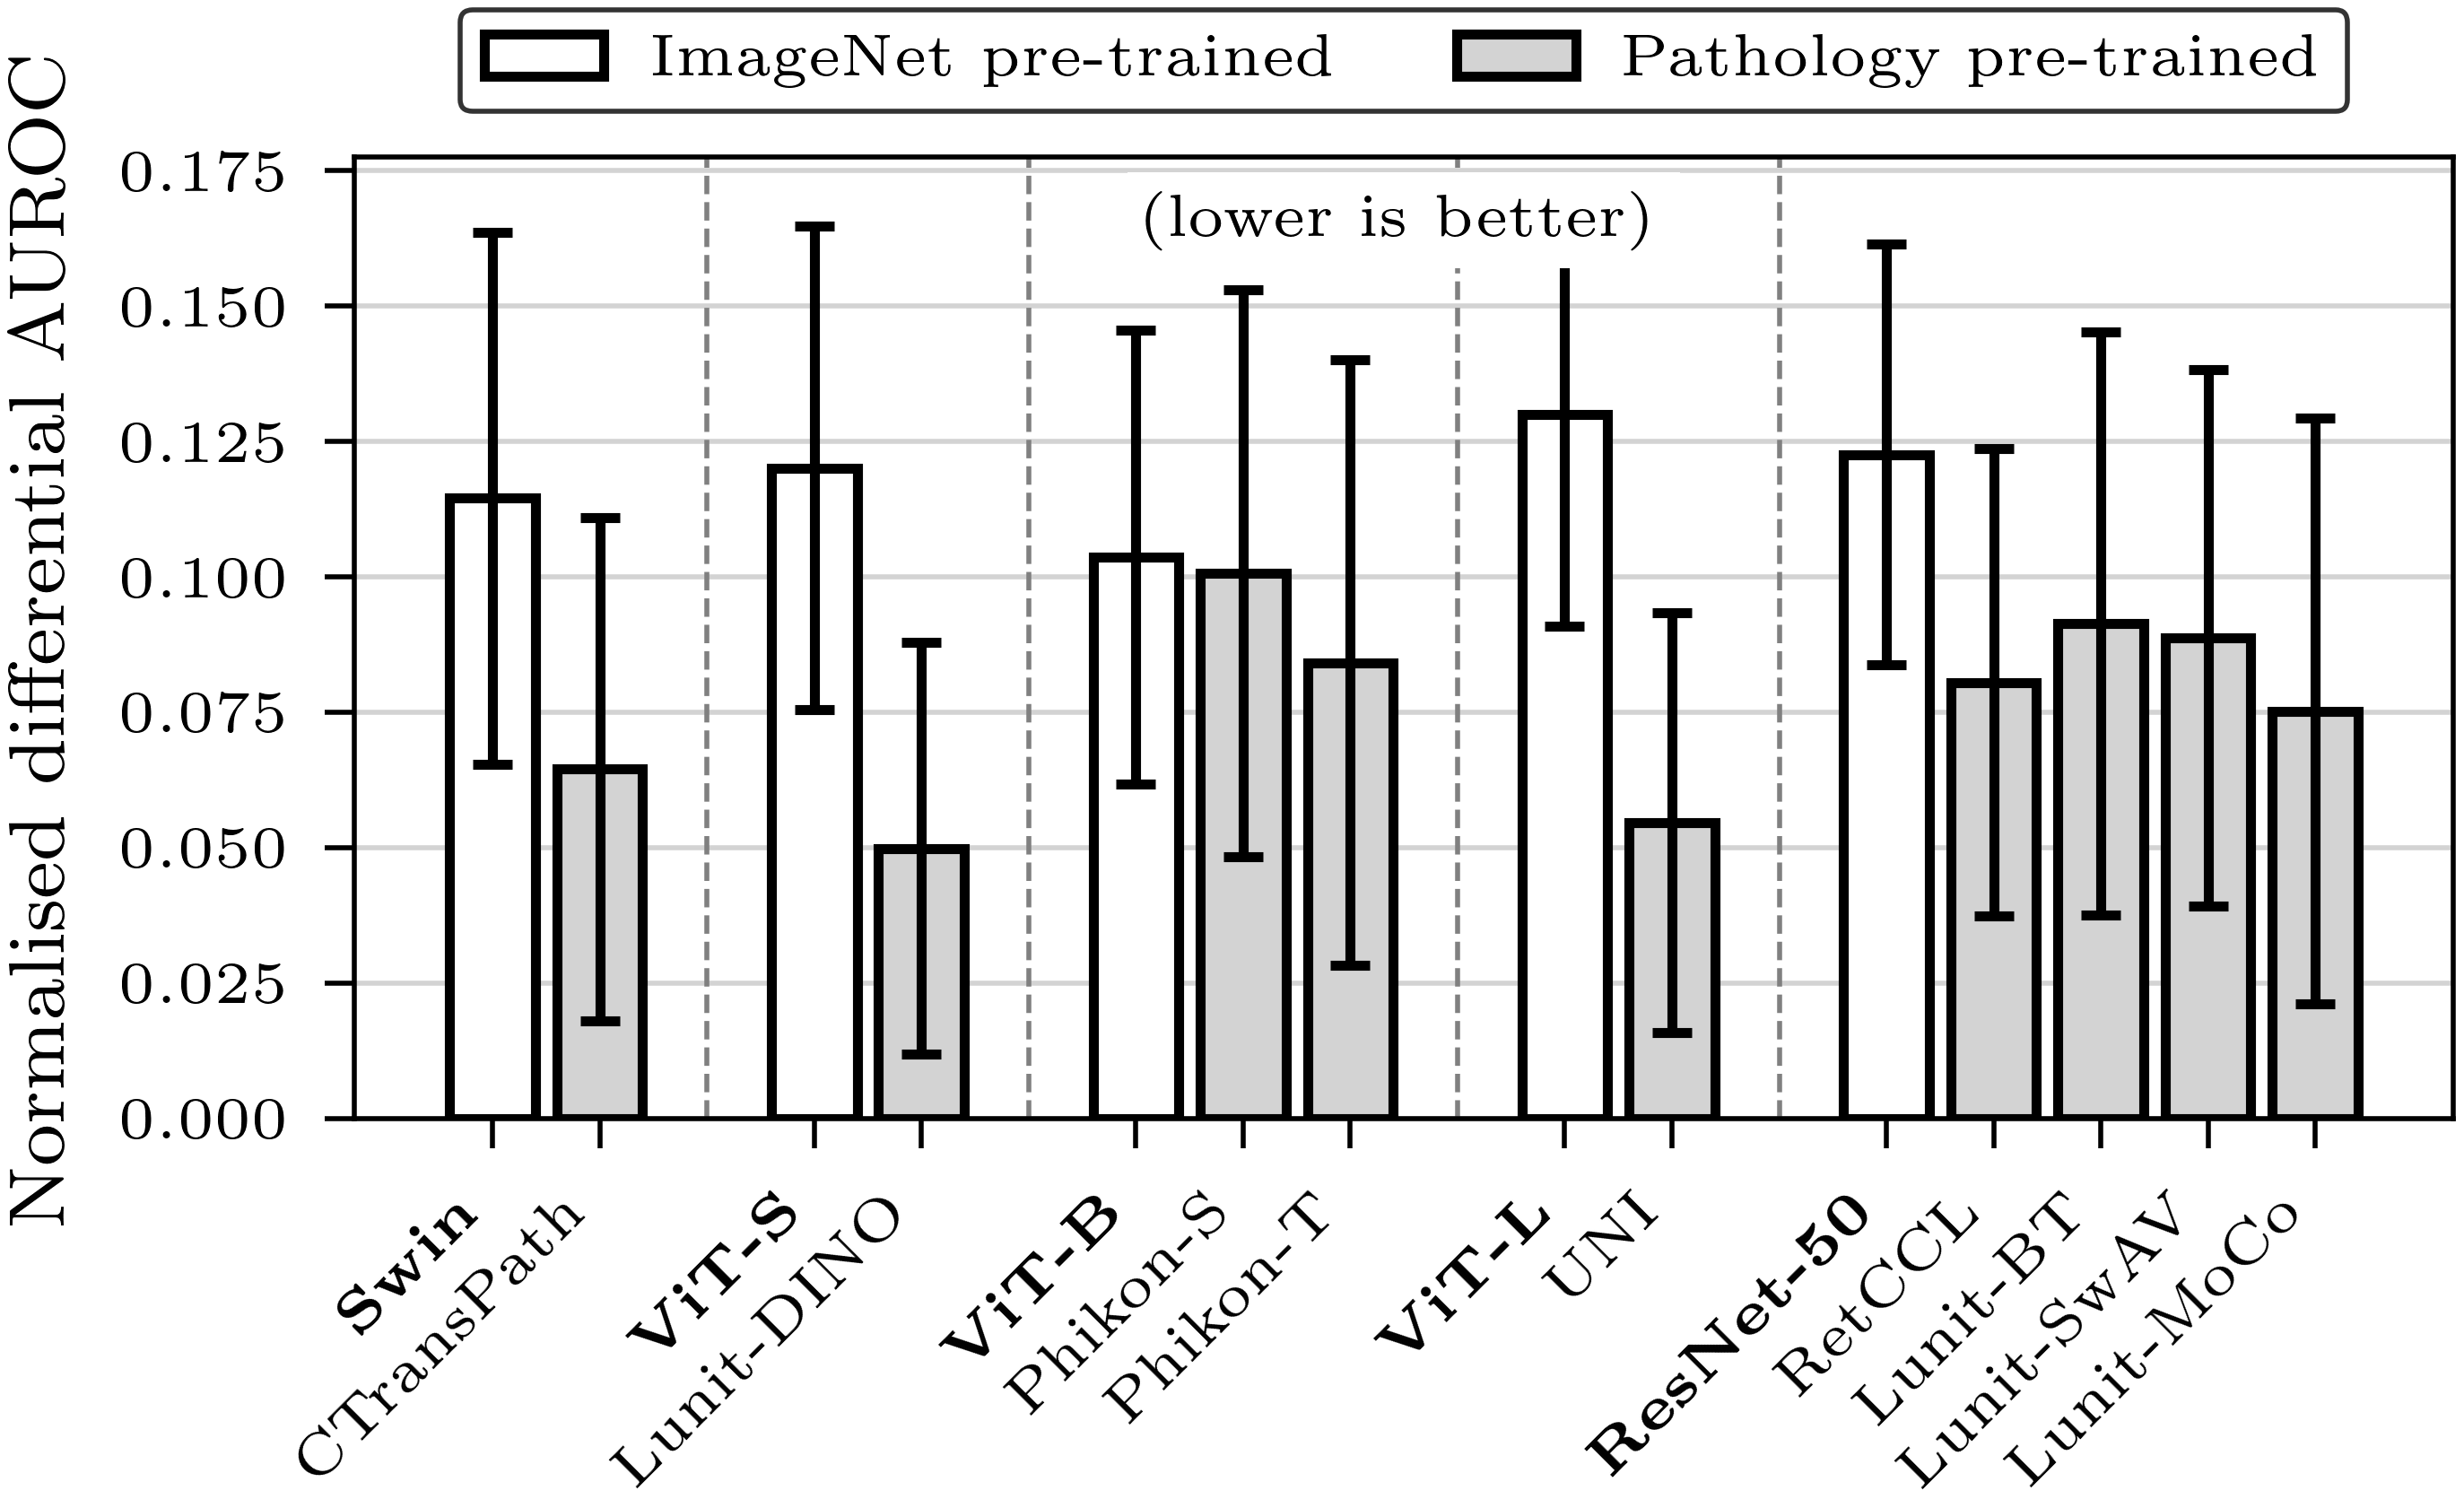

In [4]:
for model in models:

    d = (
        compute_results_table(
            results,
            keep_fixed=("magnification", "augmentations", "model", "target"),
            vary="feature_extractor",
        )
        .query("magnification == @MAGNIFICATION")
        .stack("feature_extractor")
        .unstack("target")
        .swaplevel("target", "stats", axis=1)
        .sort_index(axis=1)
    )
    d = compute_overall_average(d)["average"]
    d = d.reindex(RENAME_FEATURE_EXTRACTORS.keys(), level="feature_extractor")
    d = d.query("model == @model and augmentations=='none'")
    d["group"] = d.index.get_level_values("feature_extractor").map(
        {extractor: group for group, extractors in FEATURE_EXTRACTOR_GROUPS.items() for extractor in extractors}
    )
    d["imagenet_pretrained"] = d.groupby("group").cumcount() == 0  # first element in each group is imagenet pretrained

    with rc_context(size="half", journal=True):
        plt.figure()

        xs = d["imagenet_pretrained"].cumsum() - 1 + np.arange(len(d))

        plt.bar(
            xs[d["imagenet_pretrained"]],
            d[d["imagenet_pretrained"]]["mean"],
            # no fill, just outline
            edgecolor="black",
            linewidth=1,
            color="white",
            label="ImageNet pre-trained",
        )
        plt.bar(
            xs[~d["imagenet_pretrained"]],
            d[~d["imagenet_pretrained"]]["mean"],
            edgecolor="black",
            linewidth=1,
            color="lightgray",
            label="Pathology pre-trained",
        )

        # Error bars
        plt.errorbar(
            xs,
            d["mean"],
            yerr=d["std"],
            fmt="none",
            color="black",
            capsize=2,
            capthick=1,
            elinewidth=1,
        )

        # Rotate x-axis labels
        plt.xticks(rotation=45, ha="right")
        # plt.legend(loc="lower right", ncol=2, bbox_to_anchor=(1.0, 1.05), borderaxespad=0.0)
        plt.ylabel("Norm.\ diff.\ AUROC")
        plt.ylabel("Normalised differential AUROC")
        plt.xlabel("")

        i = 0
        xticks = []
        for group in FEATURE_EXTRACTOR_GROUPS.values():
            xticks.extend(range(i, i + len(group)))
            if i != 0:
                plt.axvline(x=i - 1, linestyle="--", color="grey", linewidth=0.5)
            i += len(group) + 1

        plt.xticks(xticks, rotation=45, ha="right")

        # set x tick labels
        plt.gca().set_xticklabels(
            [
                format_feature_extractor(RENAME_FEATURE_EXTRACTORS[extractor])
                for extractor in d.index.get_level_values("feature_extractor")
            ]
        )

        # light grey grid
        plt.grid(axis="y", color="lightgrey")
        plt.xlabel("")
        plt.legend(
            ncol=2,
            # above plot
            bbox_to_anchor=(0.5, 1.1),
            loc="center",
        )

        # lower is better label
        plt.gca().text(
            0.5,
            0.965,
            "(lower is better)",
            horizontalalignment="center",
            verticalalignment="top",
            transform=plt.gca().transAxes,
            fontsize=6,
            # white background
            bbox=dict(facecolor="white", alpha=1.0, edgecolor="none", pad=0.3, boxstyle="square"),
        )

        # plt.suptitle("Downstream performance comparison of feature extractors")

        savefig(f"performance_comparison_{MAGNIFICATION}_{model}", journal=True)
        plt.show()

## Compare augmentation groups

In [5]:
augmentation_groups_to_compare = [
    "Macenko_slidewise",
    # "Macenko_patchwise",
    "simple_rotate",
    "all",
]
if MAGNIFICATION == "high":
    augmentation_groups_to_compare = ["Macenko_patchwise"]

dfs = []
for aug in augmentation_groups_to_compare:
    df = compare_bootstraps(results, "augmentations", "none", aug)
    df["augmentation"] = aug
    dfs.append(df)

df = (
    pd.concat(dfs)
    .query("magnification == @MAGNIFICATION")
    .droplevel("magnification")
    .reset_index()
    .set_index(["augmentation", "model", "feature_extractor"])
    .drop(columns=["target"])
)
df

2024-05-28 15:40:30.066 | DEBUG    | histaug.utils.caching:wrapper:20 - Loading bootstrapped_augmentations_none_vs_Macenko_slidewise_25_c4766ef27ebd833b03e149e0ce093c9b from cache
2024-05-28 15:40:30.239 | DEBUG    | histaug.utils.caching:wrapper:20 - Loading bootstrapped_augmentations_none_vs_simple_rotate_25_c4766ef27ebd833b03e149e0ce093c9b from cache
2024-05-28 15:40:30.410 | DEBUG    | histaug.utils.caching:wrapper:20 - Loading bootstrapped_augmentations_none_vs_all_25_c4766ef27ebd833b03e149e0ce093c9b from cache


train_dataset  \
augmentation      model        feature_extractor                      
Macenko_slidewise AttentionMIL bt                     tcga_crc_BRAF   
                               bt                     tcga_crc_BRAF   
                               bt                     tcga_crc_BRAF   
                               bt                     tcga_crc_BRAF   
                               bt                     tcga_crc_BRAF   
...                                                             ...   
all               Transformer  vits               tcga_brca_subtype   
                               vits               tcga_brca_subtype   
                               vits               tcga_brca_subtype   
                               vits               tcga_brca_subtype   
                               vits               tcga_brca_subtype   

                                                        test_dataset  \
augmentation      model        feature_extractor                       
Macenko_slidewise AttentionMIL bt                     cptac_crc_BRAF   
                               bt                     cptac_crc_BRAF   
                               bt                     cptac_crc_BRAF   
                               bt                     cptac_crc_BRAF   
                               bt                     cptac_crc_BRAF   
...                                                              ...   
all               Transformer  vits               cptac_brca_subtype   
                               vits               cptac_brca_subtype   
                               vits               cptac_brca_subtype   
                               vits               cptac_brca_subtype   
                               vits               cptac_brca_subtype   

                                                  auroc_diff  
augmentation      model        feature_extractor              
Macenko_slidewise AttentionMIL bt                   0.047101  
                               bt                   0.105676  
                               bt                   0.048889  
                               bt                   0.079106  
                               bt                  -0.021120  
...                                                      ...  
all               Transformer  vits                 0.042156  
                               vits                 0.005171  
                               vits                 0.101888  
                               vits                 0.087075  
                               vits                 0.036674  

[141750 rows x 3 columns]

In [16]:
models = ["AttentionMIL", "Transformer", "MeanAveragePooling"] if MAGNIFICATION == "low" else ["AttentionMIL"]

from histaug.analysis.collect_results import compute_results_table
from histaug.utils import rc_context, savefig

df["Feature extractor"] = (
    df.index.get_level_values("feature_extractor").map(RENAME_FEATURE_EXTRACTORS).map(format_feature_extractor)
)
df["Augmentation"] = df.index.get_level_values("augmentation").map(
    lambda x: {
        "Macenko_slidewise": "\\textrm{stain normalisation}",
        "simple_rotate": "\\textrm{rotate/flip}",
        "all": "\\textrm{all augmentations}",
    }.get(x, x)
)
# with rc_context(size="full", journal=True, nrows=len(models), ncols=3, h=1.2):
#     fig = plt.figure()
#     gridspecs = fig.add_gridspec(len(models), 1)

#     sns.set_palette("Paired")

#     for i_model, model in enumerate(models):
#         gs1 = gridspecs[i_model, 0]
#         # gs2 = gridspecs[i_model, 1]

#         # Create the first subplot
#         ax1 = fig.add_subplot(gs1)

#         # horizontal line at 0
#         hline = plt.axhline(0, color="black", linewidth=0.5)

#         # Boxplot with 95% confidence interval
#         boxplot = sns.boxplot(
#             data=df.query("model == @model"),
#             x="Augmentation",
#             y="auroc_diff",
#             hue="Feature extractor",
#             hue_order=[
#                 format_feature_extractor(RENAME_FEATURE_EXTRACTORS[x])
#                 for x in itertools.chain.from_iterable(FEATURE_EXTRACTOR_GROUPS.values())
#             ],
#             # ensure 95% confidence interval is shown
#             showfliers=False,
#             whis=[2.5, 97.5],
#             # show all data points
#             # showmeans=True,
#             width=0.85,
#         )

#         # plt.legend(loc="lower right", ncol=2, bbox_to_anchor=(1.0, 1.05), borderaxespad=0.0)
#         # plt.legend(loc="upper left", ncol=2)
#         plt.gca().get_legend().remove()
#         plt.ylabel("Change in test AUROC")
#         plt.xlabel("")

#         # plt.xticks(rotation=45, ha="right")

#         # light grey grid
#         plt.grid(axis="y", color="lightgrey")
#         plt.xlabel("")
#         plt.gca().tick_params(axis="x", which="both", length=0)
#         plt.title(
#             f"Effect of augmentation on downstream performance"
#             if len(models) == 1
#             else f"Effect of augmentation on performance ({RENAME_MODELS[model]})"
#         )

#         ax1.set_xlim(-0.5, 2.5)
#         ax1.set_ylim(-0.43, 0.43)

#         # tick_fontsize = ax1.xaxis.get_ticklabels()[0].get_fontsize() + 2
#         # ax1.xaxis.set_tick_params(labelsize=tick_fontsize)

#     # Put legend underneath whole figure
#     hl = np.array(ax1.get_legend_handles_labels()).T
#     i = 0
#     leg = []
#     dummy_patch_handle = mpl.patches.Patch(color="none", label="dummy")
#     leg.append((dummy_patch_handle, ""))
#     for group in FEATURE_EXTRACTOR_GROUPS:
#         for extractor in FEATURE_EXTRACTOR_GROUPS[group]:
#             leg.append(hl[i])
#             i += 1
#     # leg.append((dummy_patch_handle, ""))

#     hl = np.array(leg).T
#     legend = plt.figlegend(
#         *hl,
#         bbox_to_anchor=(1.01, 0.5),
#         loc="center left",
#         ncol=1,
#         borderaxespad=0.0,
#         columnspacing=0.3,
#         handletextpad=0.5,
#         labelspacing=0.45,
#         # title="Extractor",
#     )

#     cumulative = -1.0
#     indices_of_labels_to_move = np.cumsum([len(extractors) for extractors in FEATURE_EXTRACTOR_GROUPS.values()])[:-1]
#     for idx, text in enumerate(legend.get_texts()):
#         # if idx == 0:
#         #     continue
#         if idx - 1 in indices_of_labels_to_move:  # Indices of the labels after which we want more space
#             # We move the label and the corresponding line (handle) downwards
#             cumulative += 2.5
#         cumulative -= idx * 0.02
#         text.set_transform(text.get_transform() + mpl.transforms.Affine2D().translate(0, -cumulative + 6))
#         legend.legend_handles[idx].set_y(legend.legend_handles[idx].get_y() - cumulative + 6)
#         # legend.legend_handles[idx].set_transform(legend.legend_handles[idx ].get_transform() + mpl.transforms.Affine2D().translate(0, -cumulative))
#         # leg.legendHandles[idx + 1]._legmarker.set_transform(leg.legendHandles[idx + 1]._legmarker.get_transform() + mpl.transforms.Affine2D().translate(0, -10))

#     savefig(f"augmentations_performance_{MAGNIFICATION}_{'_'.join(models)}", journal=True)
#     plt.show()

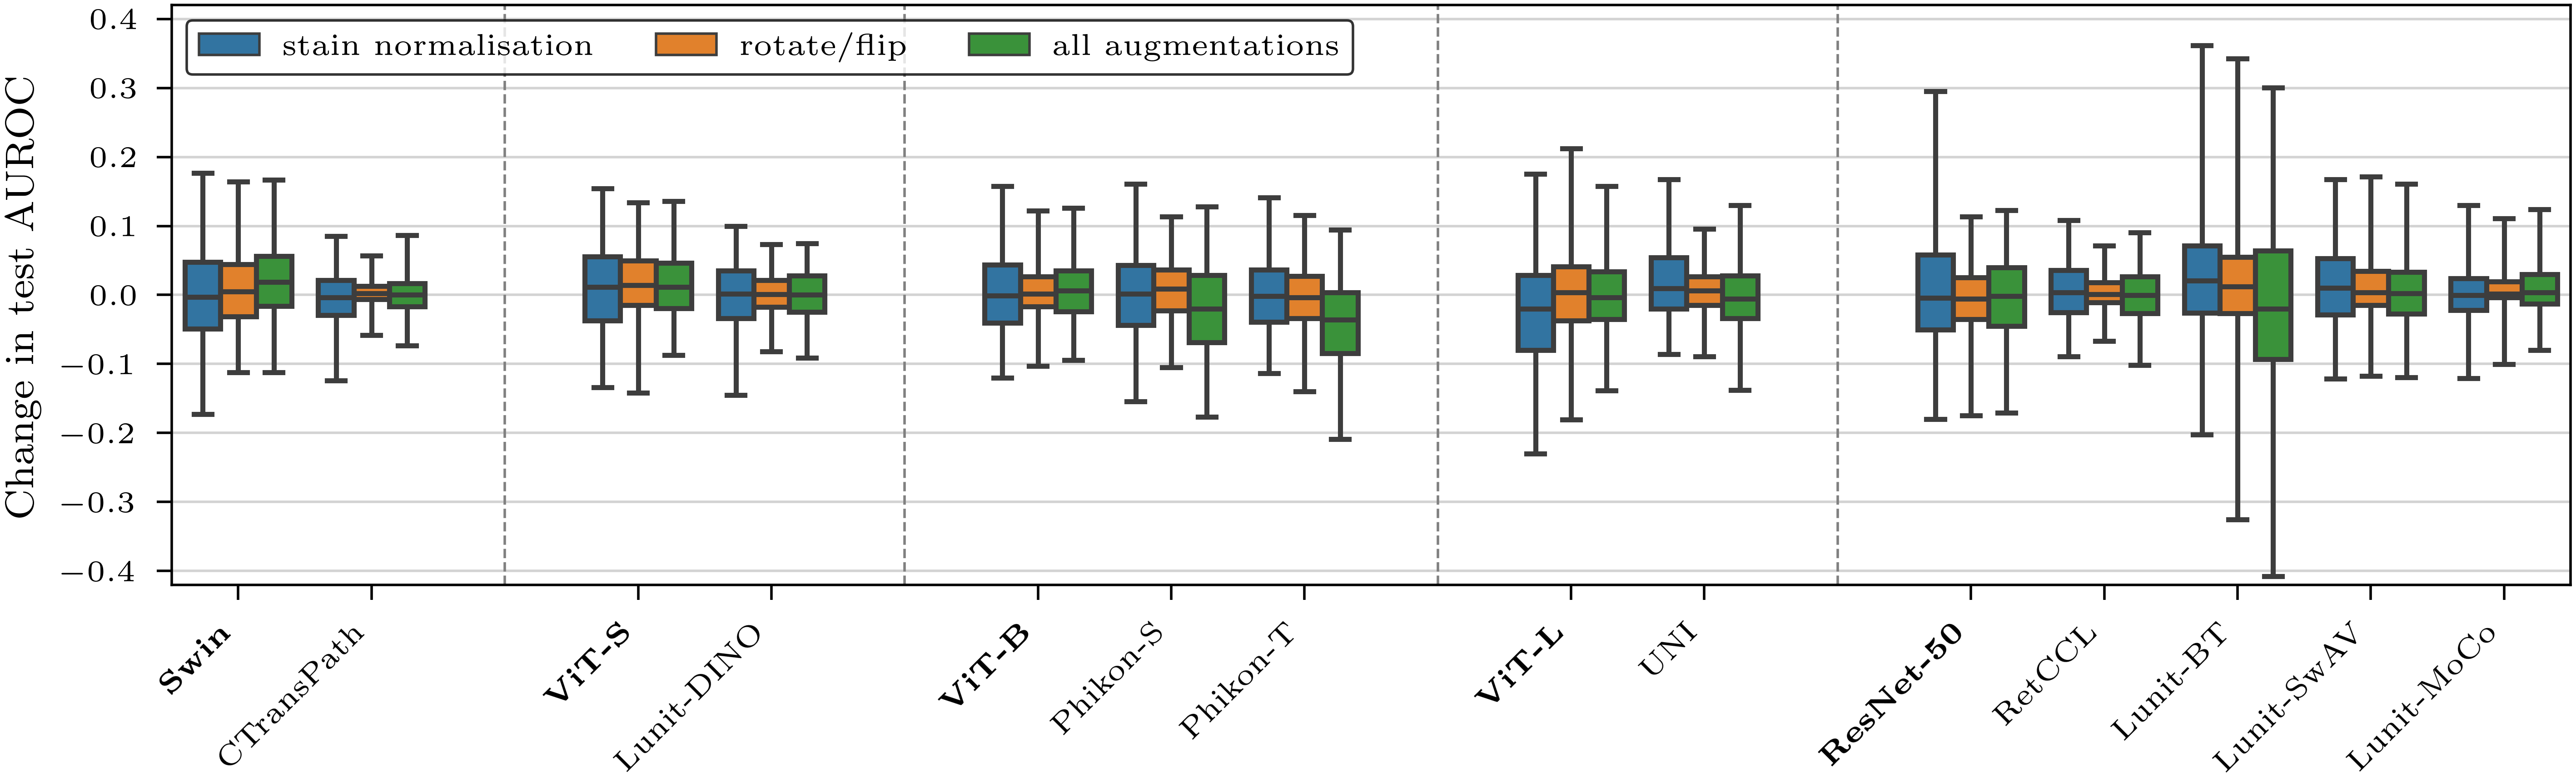

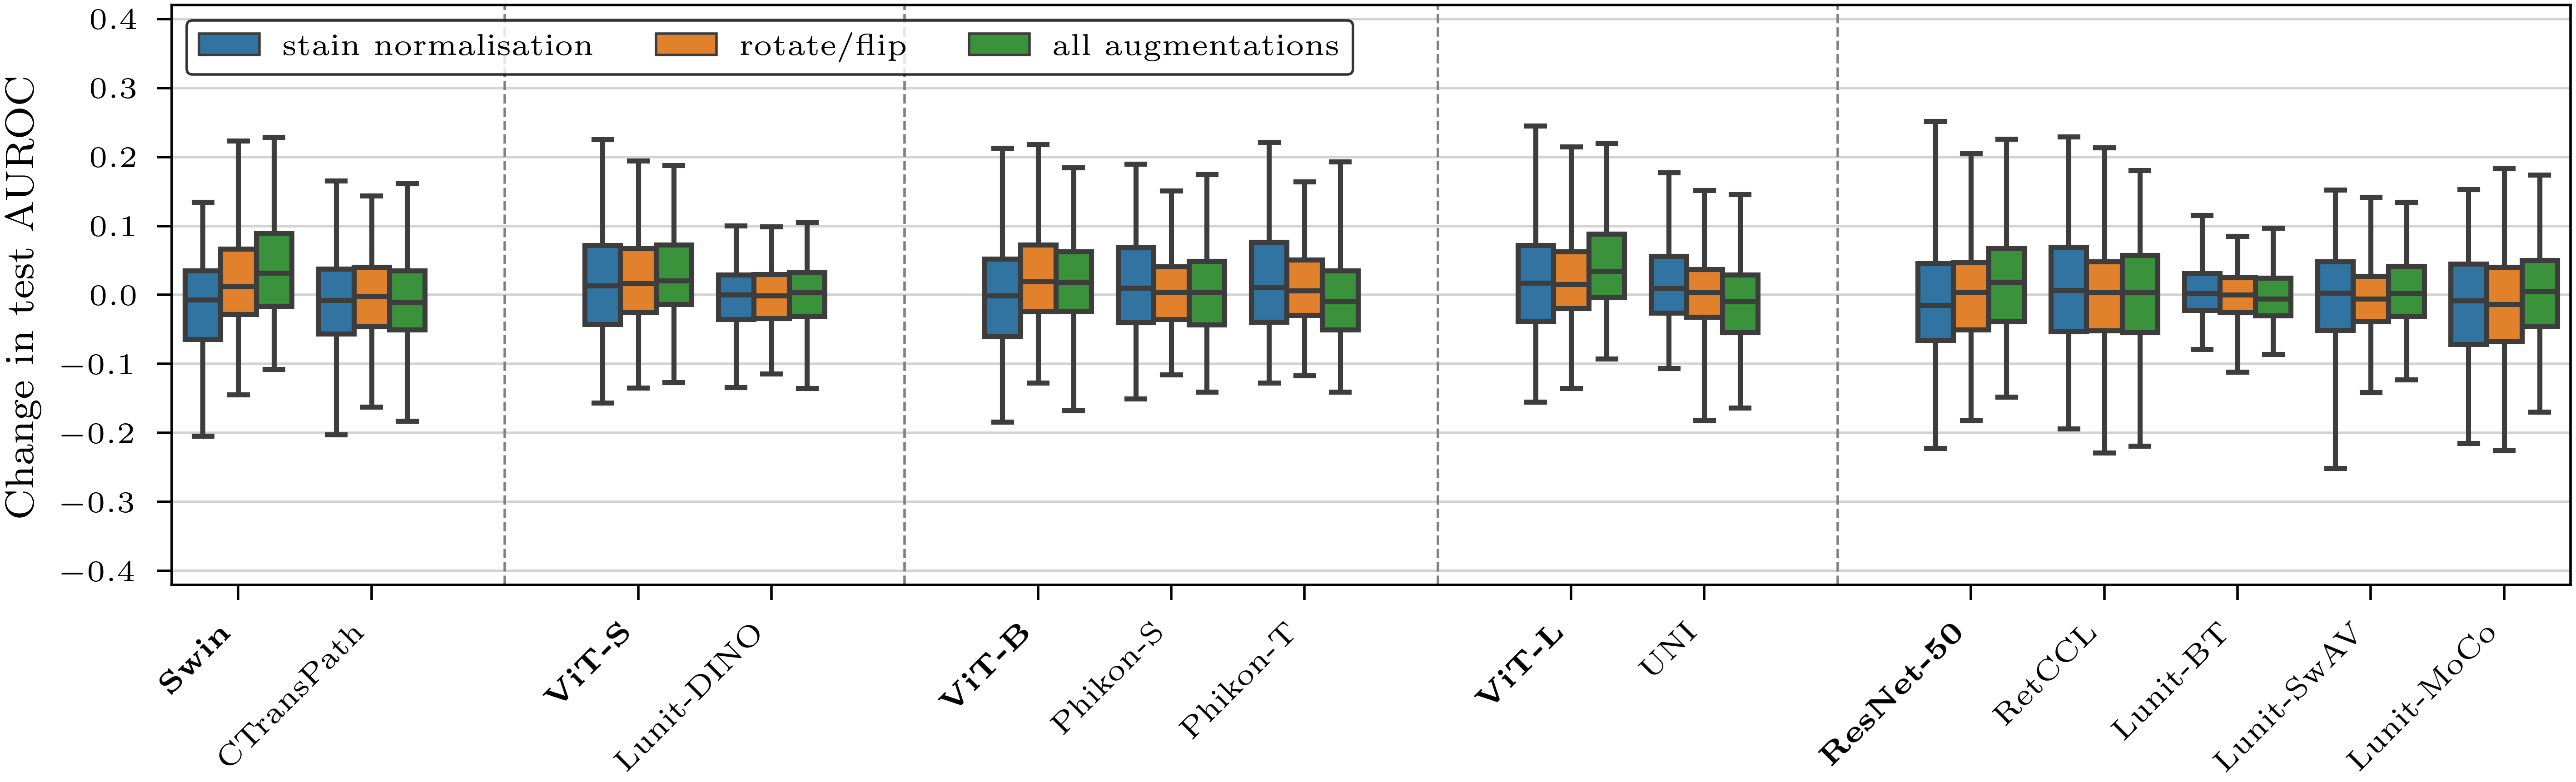

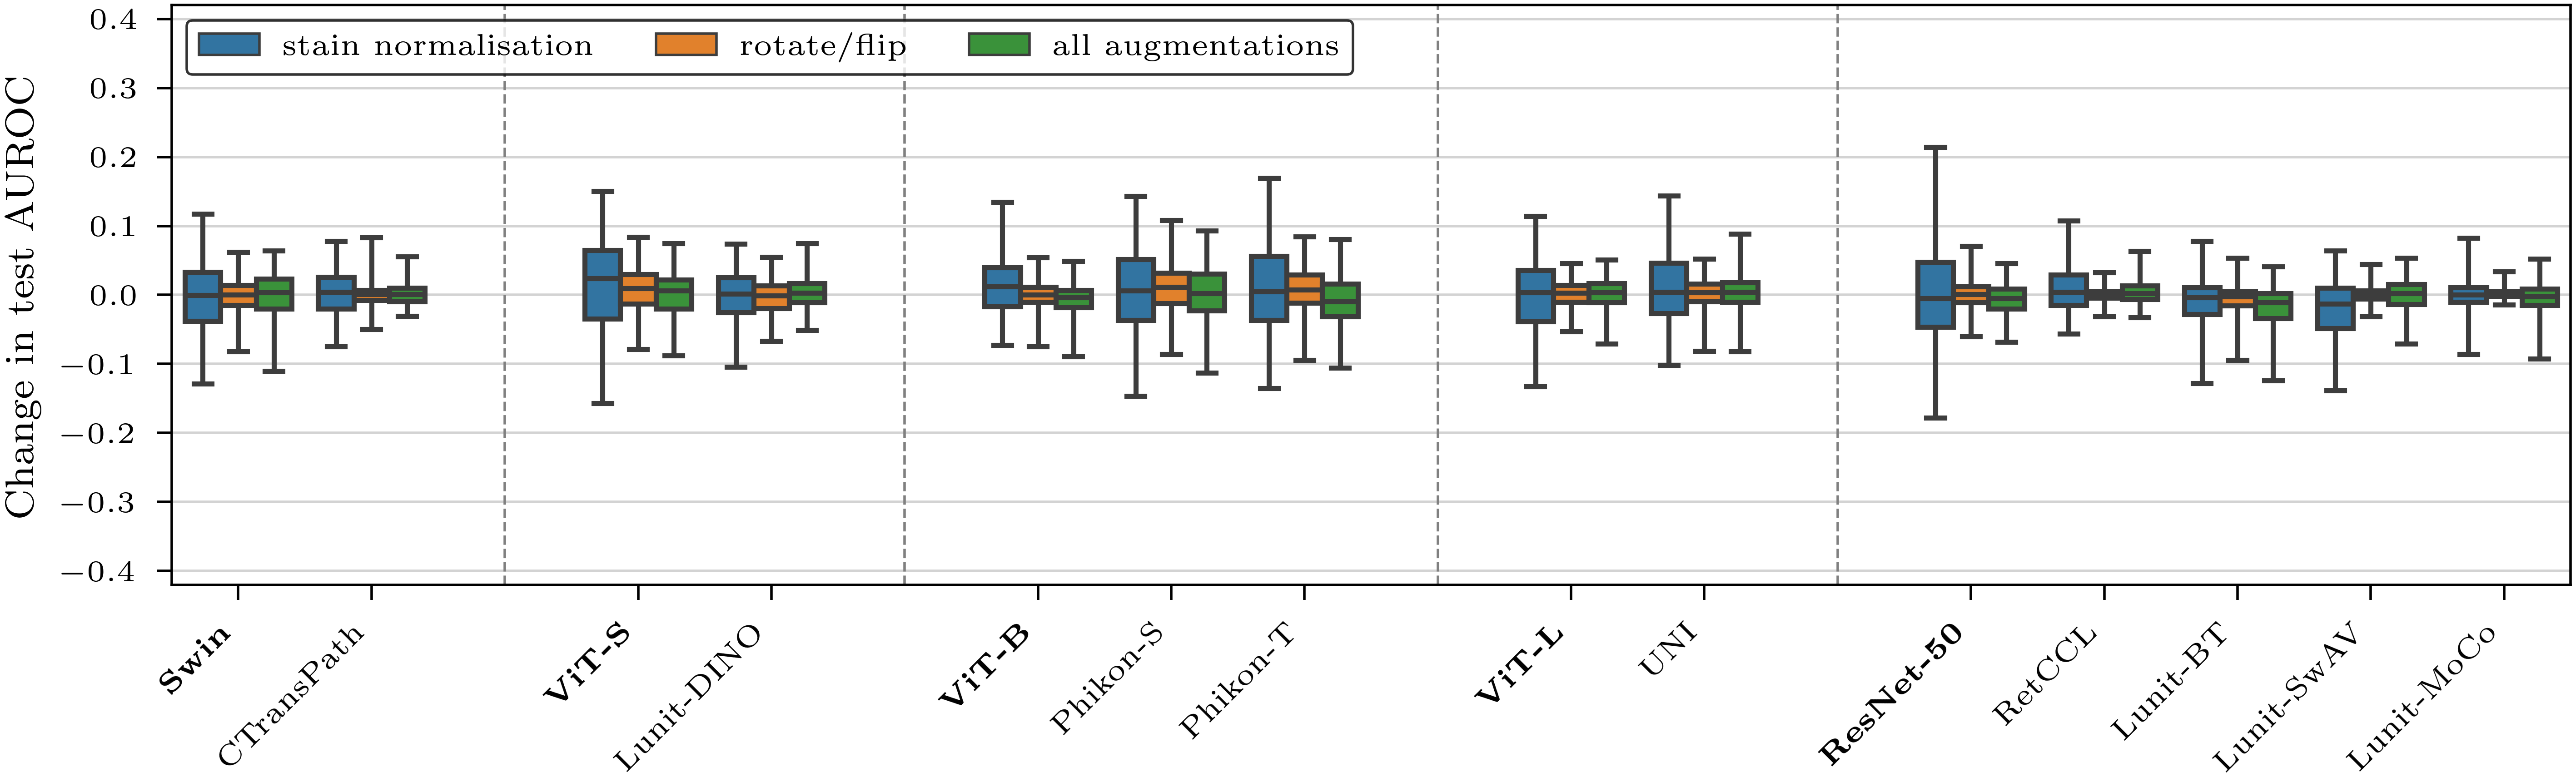

In [26]:
for model in models:
    with rc_context("full", journal=True, h=0.5):
        # Boxplot with 95% confidence interval
        sns.boxplot(
            data=df.query("model == @model"),
            # data=df.query("model == @model and augmentation == @augmentation"),
            x="Feature extractor",
            y="auroc_diff",
            hue="Augmentation",
            order=[
                x
                for y in [
                    [
                        *([" " * i] if i != 0 else []),
                        *[format_feature_extractor(RENAME_FEATURE_EXTRACTORS[extractor]) for extractor in extractors],
                    ]
                    for i, extractors in enumerate(FEATURE_EXTRACTOR_GROUPS.values())
                ]
                for x in y
            ],
            # ensure 95% confidence interval is shown
            showfliers=False,
            whis=[2.5, 97.5],
            # show all data points
            # showmeans=True,
            # ax=ax
        )

        # Rotate x-axis labels
        plt.xticks(rotation=45, ha="right")
        # plt.legend(loc="lower right", ncol=2, bbox_to_anchor=(1.0, 1.05), borderaxespad=0.0)
        plt.legend(loc="upper left", ncol=3)
        plt.ylabel("Change in test AUROC")
        plt.xlabel("")
        plt.ylim(-0.42, 0.42)

        i = 0
        xticks = []
        for group in FEATURE_EXTRACTOR_GROUPS.values():
            xticks.extend(range(i, i + len(group)))
            if i != 0:
                plt.axvline(x=i - 1, linestyle="--", color="grey", linewidth=0.5)
            i += len(group) + 1

        plt.xticks(xticks, rotation=45, ha="right")

        # light grey grid
        plt.grid(axis="y", color="lightgrey")
        plt.xlabel("")
        # plt.title("Performance with vs.\\ without stain normalisation (AttMIL)")
        savefig(f"augmentations_performance_{MAGNIFICATION}_{model}", journal=True)
        plt.show()